In [1]:
import sys
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner

In [2]:
from train_multimodal_simflower import TrainMultimodalSimformer, get_batch_fn_factory
from multimodal_domain_adapter import ModalityDomainAdapter
from init_adapters_encoders import initialize_adapters_and_encoders
from flow_loss_forward import SimformerLossWrapper
from posterior_euler_sampler import sample_posterior

In [4]:
sys.path.append("/Users/ratzenboe/Documents/work/projects/AstroSimformer/dev_jax_flow/core/")
from build_transformer_model import build_transformer_model
from config_class import load_config

ImportError: cannot import name 'load_config' from 'config_class' (/Users/ratzenboe/Documents/work/projects/AstroSimformer/dev_simformer_slim/config_class.py)

# Load data

In [4]:
fname_basel = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_field_1kpc_fundamentals_Bayestar2019_SED_BaSeL_June2025.parquet'
fname_btsettl = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_field_1kpc_fundamentals_Edenhofer_SED_BTSettl_June2025_diffClusters.parquet'

df_sim = pd.read_parquet(fname_basel)
df_sim['dist'] = 1000./df_sim['parallax']
df_real = pd.read_parquet(fname_btsettl)
df_real['dist'] = 1000./df_real['parallax']

N = df_sim.shape[0]

# Define features

In [5]:
feats_theta = [
    'mass', 'logAge', 'Z_metal', 'Av', 'dist'
]

lamost_cols = [col for col in df_sim.columns if 'lamost_' in col]
apogee_cols = [col for col in df_sim.columns if 'apogee_' in col]
boss_cols   = [col for col in df_sim.columns if 'boss_' in col]
xp_cols     = [col for col in df_sim.columns if 'xp_' in col]

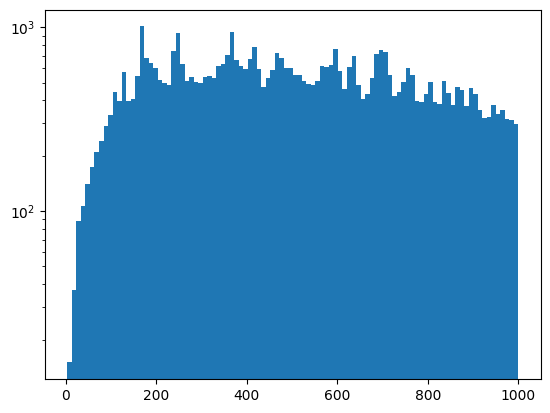

In [6]:
plt.hist(df_sim['dist'], bins=100, log=True);

# Randomly remove values

In [7]:
set_nans = False

In [8]:
# Randomly drop Gaia, Spitzer, 2MASS, or Wise photometry
gaia_cols = ['gaia_bp_phot', 'gaia_rp_phot', 'gaia_g_phot', 'parallax_obs']
tmass_cols = ['2mass_h', '2mass_j', '2mass_k']
spitzer_cols = ['irac_1', 'irac_2', 'irac_3', 'irac_4']
wise_cols = ['wise_1', 'wise_2', 'wise_3', 'wise_4']
phot_cols = [gaia_cols, tmass_cols, spitzer_cols, wise_cols]
# Random drop rate
drop_rate_gaia = 0.1
drop_rate_tmass = 0.2
drop_rate_spitzer = 0.9
drop_rate_wise = 0.5
drs = [drop_rate_gaia, drop_rate_tmass, drop_rate_spitzer, drop_rate_wise]

if set_nans:
    # Set values to nan
    for dr, cols in zip(drs, phot_cols):
        rows_to_nan_sim = np.random.choice(N, size=int(N * dr), replace=False)
        rows_to_nan_real = np.random.choice(N, size=int(N * dr), replace=False)
        # Set selected rows to NaN
        df_sim.loc[rows_to_nan_sim, cols] = np.nan
        df_real.loc[rows_to_nan_real, cols] = np.nan
else:
    df_sim = df_sim.dropna().reset_index(drop=True)
    df_real = df_real.dropna().reset_index(drop=True)

In [9]:
same_idx = np.intersect1d(df_real['idx2match'].values, df_sim['idx2match'].values)

In [10]:
df_sim_sub = df_sim.loc[df_sim.idx2match.isin(same_idx)]
df_real_sub = df_real.loc[df_real.idx2match.isin(same_idx)]
df_sim_sub = df_sim_sub.set_index('idx2match').reindex(same_idx).reset_index()
df_real_sub = df_real_sub.set_index('idx2match').reindex(same_idx).reset_index()

In [11]:
# --- Define modalities and dimensions ---
modalities = ['xp', 'lamost', 'boss', 'apogee' , 'gaia_phot', '2mass_phot', 'wise_phot', 'spitzer_phot']
input_cols = {
    'xp': xp_cols,
    'lamost': lamost_cols,
    'boss': boss_cols,
    'apogee': apogee_cols,
    'gaia_phot': gaia_cols,
    '2mass_phot': tmass_cols,
    'wise_phot': wise_cols,
    'spitzer_phot': spitzer_cols,
}
input_dims = {
    'xp': len(xp_cols),
    'lamost': len(lamost_cols),
    'boss': len(boss_cols),
    'apogee': len(apogee_cols),
    'gaia_phot': len(gaia_cols),
    '2mass_phot': len(tmass_cols),
    'wise_phot': len(wise_cols),
    'spitzer_phot': len(spitzer_cols),
}
latent_dims = {
    'xp': 128,
    'lamost': 128,
    'boss': 128,
    'apogee': 128,
    'gaia_phot': 8,
    '2mass_phot': 8,
    'wise_phot': 8,
    'spitzer_phot': 8
}
trafo_dict = load_config('../simformer_config.json')
# --- Create toy data ---
key = jax.random.PRNGKey(0)
BATCH_SIZE = 2**10

# Store training data
sim_data = {mod: df_sim[input_cols[mod]].values for mod in modalities}
sim_data['theta'] = df_sim[feats_theta].values
real_data = {mod: df_real[input_cols[mod]].values for mod in modalities}
pair_data = {mod: (df_sim_sub[input_cols[mod]].values, df_real_sub[input_cols[mod]].values) for mod in modalities}
# Test data with "real" matched to simulated theta
test_data = {mod: df_real_sub[input_cols[mod]].values for mod in modalities} | {'theta': df_real_sub[feats_theta].values}

# Normalize spectra

In [12]:
normalization_info = {}
sim_data_normed = {}
real_data_normed = {}
pair_data_normed = {}
test_data_normed = {}
spec_cols = ['xp', 'lamost', 'boss', 'apogee']

for mod in sim_data.keys():
    if mod in spec_cols:
        # Log normalization for spectra and normalize over entire spectra not per pixel
        log_mean_val = np.nanmean(np.log10(sim_data[mod]))
        log_std_val = np.nanstd(np.log10(sim_data[mod]))
        # Normalize values
        sim_mod_normed = (np.log10(sim_data[mod]) - log_mean_val) / log_std_val
        real_mod_normed = (np.log10(real_data[mod]) - log_mean_val) / log_std_val
        pair_sim_mod_normed = (np.log10(pair_data[mod][0]) - log_mean_val) / log_std_val
        pair_real_mod_normed =  (np.log10(pair_data[mod][1]) - log_mean_val) / log_std_val
        test_mod_normed = (np.log10(test_data[mod]) - log_mean_val) / log_std_val
        normalization_info[mod] = {'mean': log_mean_val, 'std': log_std_val, 'log': True}
        # Set
        sim_data_normed[mod] = sim_mod_normed
        real_data_normed[mod] = real_mod_normed
        pair_data_normed[mod] = (pair_sim_mod_normed, pair_real_mod_normed)
        test_data_normed[mod] = test_mod_normed
    else:
        mean_val = np.nanmean(sim_data[mod], axis=0)
        std_val = np.nanstd(sim_data[mod], axis=0)
        normalization_info[mod] = {'mean': mean_val, 'std': std_val, 'log': False}
        # Normalize values
        sim_mod_normed = (sim_data[mod] - mean_val) / std_val
        test_mod_normed = (test_data[mod] - mean_val) / std_val
        # Set
        sim_data_normed[mod] = sim_mod_normed
        test_data_normed[mod] = test_mod_normed
        if mod in real_data:
            real_mod_normed = (real_data[mod] - mean_val) / std_val
            pair_sim_mod_normed = (pair_data[mod][0] - mean_val) / std_val
            pair_real_mod_normed = (pair_data[mod][1] - mean_val) / std_val
            real_data_normed[mod] = real_mod_normed
            pair_data_normed[mod] = (pair_sim_mod_normed, pair_real_mod_normed)

In [13]:
sim_data_normed['theta'][:,1]

array([ 0.78937787,  0.67483465,  0.69269311, ..., -2.53460453,
       -1.46002534, -1.19559101])

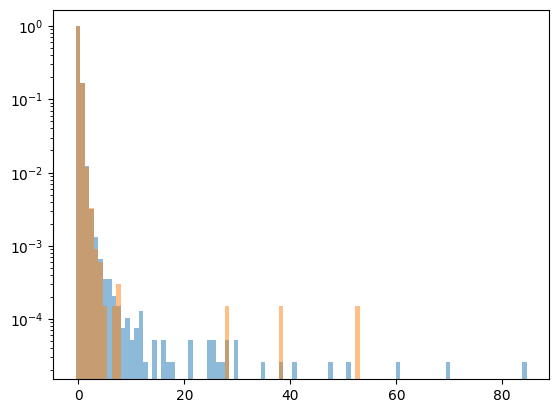

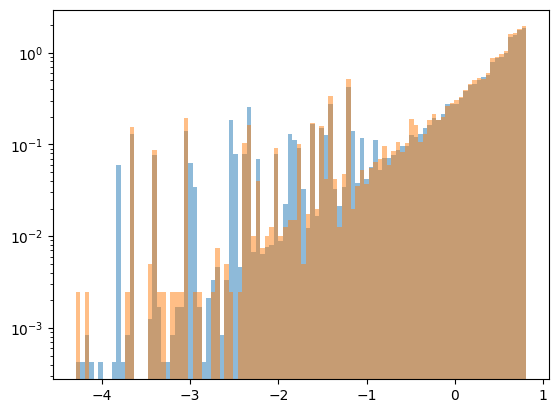

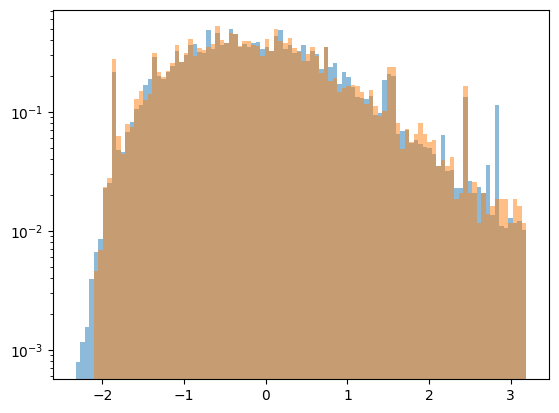

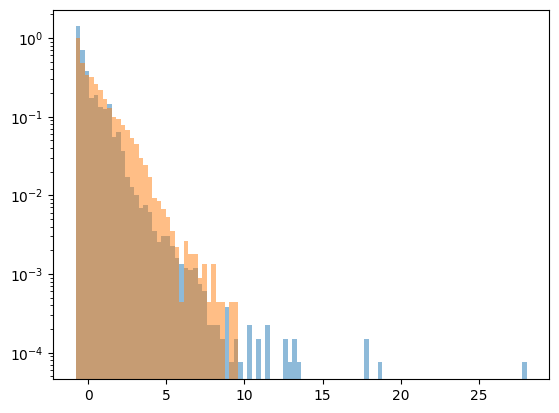

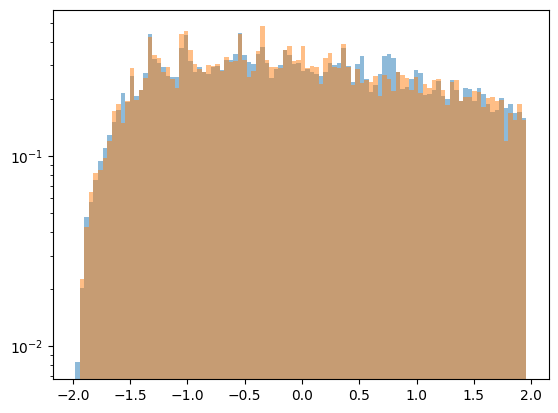

In [14]:
for i in range(5):
    _, bins, _ = plt.hist(sim_data_normed['theta'][:,i], bins=100, label='simulated', alpha=0.5, density=True, log=True)
    plt.hist(test_data_normed['theta'][:, i], bins=bins, label='real', alpha=0.5, density=True, log=True)
    plt.show()

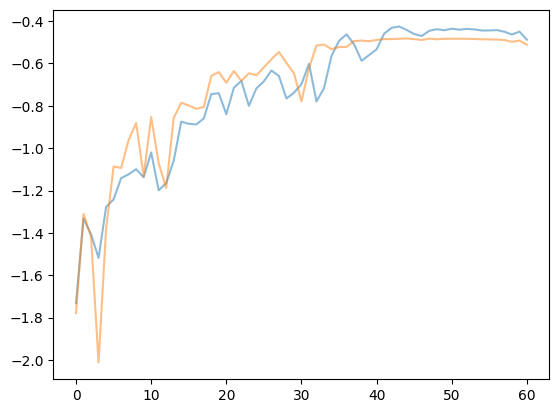

In [15]:
for i in range(18,19):
    plt.plot(pair_data_normed['xp'][0][i], label='simulated', c='C0', alpha=0.5)
    plt.plot(pair_data_normed['xp'][1][i], label='real', c='C1', alpha=0.5)
# plt.legend()
plt.show()

In [16]:
# --- Initialize encoders/adapters ---
adapters, encoders = initialize_adapters_and_encoders(
    input_dims=input_dims,
    latent_dims=latent_dims,
    key=key,
    dropout_rate=0.1,
    use_batchnorm=True
)

# --- Define modality merging behavior ---
average_groups = [{'xp', 'lamost', 'boss'}]  # pool all spectra

domain_adapter = ModalityDomainAdapter(
    adapters=adapters,
    encoders=encoders,
    ordered_modalities=modalities,
    average_groups=average_groups,
    contrast_groups=[],
    use_ot=True,
    use_contrastive=True
)

In [17]:
# --- Simformer model init ---
# Calculate total number of latent dimensionality in the model, subtracting the averaged modalities
nodes_max = sum(latent_dims.values()) + len(feats_theta) #- (len(average_groups[0])-1) * latent_dims[list(average_groups[0])[0]]
model_init, model_fn = build_transformer_model(
    nodes_max=nodes_max,
    dim_value=trafo_dict['dim_value'],
    dim_id=trafo_dict['dim_id'],
    dim_condition=trafo_dict['dim_condition'],
    num_heads=trafo_dict['num_heads'],
    num_layers=trafo_dict['num_layers'],
    attn_size=trafo_dict['attn_size'],
    widening_factor=trafo_dict['widening_factor'],
    embed_time_dim=128
)

x0 = jnp.zeros((BATCH_SIZE, nodes_max, 1))
t = jnp.ones((BATCH_SIZE, 1))
node_ids = jnp.arange(nodes_max)
cond_mask = jnp.zeros_like(node_ids).astype(jnp.float32)
edge_mask = jnp.ones((BATCH_SIZE, nodes_max, nodes_max), dtype=bool)
params = model_init(key, t, x0, node_ids, cond_mask, edge_mask)

loss_wrapper = SimformerLossWrapper(
    model_fn=model_fn,
)

# --- Dataset & batching ---
dataset = {
    "sim": {mod: sim_data_normed[mod] for mod in modalities} | {"theta": sim_data["theta"]},
    "real": {mod: real_data_normed[mod] for mod in modalities},
    "pair": {mod: pair_data_normed[mod] for mod in modalities}
}

get_batch_fn = get_batch_fn_factory(dataset, modalities, sim_theta_key="theta", batch_size=BATCH_SIZE)

# --- Config and trainer ---
config = {
    "lr": 1e-3,
    "lambda_aux": 1.0,
    "lambda_pairwise": 1.0,
    "lambda_ot_xp": 1.0,
    "lambda_ot_lamost": 1.0,
    "lambda_ot_boss": 1.0,
    "lambda_ot_apogee": 1.0,
    "lambda_ot_gaia_phot": 1.0,
    "lambda_ot_2mass_phot": 1.0,
    "lambda_ot_wise_phot": 1.0
}

In [18]:
trainer = TrainMultimodalSimformer(
    key=key,
    domain_adapter=domain_adapter,
    model_fn=model_fn,
    params=params,
    flow_matching_loss_fn=loss_wrapper,
    config=config,
    get_batch_fn=get_batch_fn,
    inner_train_loop_size=5,
    early_stopping_patience=3,
    model_check_point_dir='./model_checkpts'
)

In [19]:
trainer.fit(epochs=10)

Epoch 1: loss = 2156.052002, details = {'flow_matching': Array(1073.9739, dtype=float32), 'ot_2mass_phot': Array(0.04687015, dtype=float32), 'ot_apogee': Array(0.1191057, dtype=float32), 'ot_boss': Array(0.13728084, dtype=float32), 'ot_gaia_phot': Array(0.0754202, dtype=float32), 'ot_lamost': Array(0.18089558, dtype=float32), 'ot_spitzer_phot': Array(0.08203118, dtype=float32), 'ot_wise_phot': Array(0.03600996, dtype=float32), 'ot_xp': Array(0.17923763, dtype=float32), 'pairwise': Array(0.18644217, dtype=float32), 'real_contrast_boss_lamost': Array(0.9673034, dtype=float32), 'real_contrast_boss_xp': Array(1.0736233, dtype=float32), 'real_contrast_lamost_xp': Array(0.9678367, dtype=float32), 'total_loss': Array(1078.026, dtype=float32)}
Checkpoint saved to ./model_checkpts/model_checkpoint_epoch_0.pkl
Epoch 2: loss = 2128.346924, details = {'flow_matching': Array(1060.1154, dtype=float32), 'ot_2mass_phot': Array(0.04666567, dtype=float32), 'ot_apogee': Array(0.11819562, dtype=float32), 

KeyboardInterrupt: 

# Sample from posterior

In [17]:
test_modality_inputs = {mod: test_data_normed[mod][:10] for mod in modalities}
test_theta = test_data_normed['theta'][:10]
rng = jax.random.PRNGKey(0)

In [18]:
model_fn = model_fn
params = trainer.best_params
domain_adapter = trainer.flow_model.domain_adapter
inputs = test_modality_inputs

In [19]:
samples_post = sample_posterior(
    model_fn=model_fn,
    params=params,
    key=key,
    inputs=inputs,
    domain_adapter=domain_adapter,
    theta_dim=len(feats_theta),
    num_samples=100,
)

In [21]:
samples_post_np = jax.device_get(samples_post)

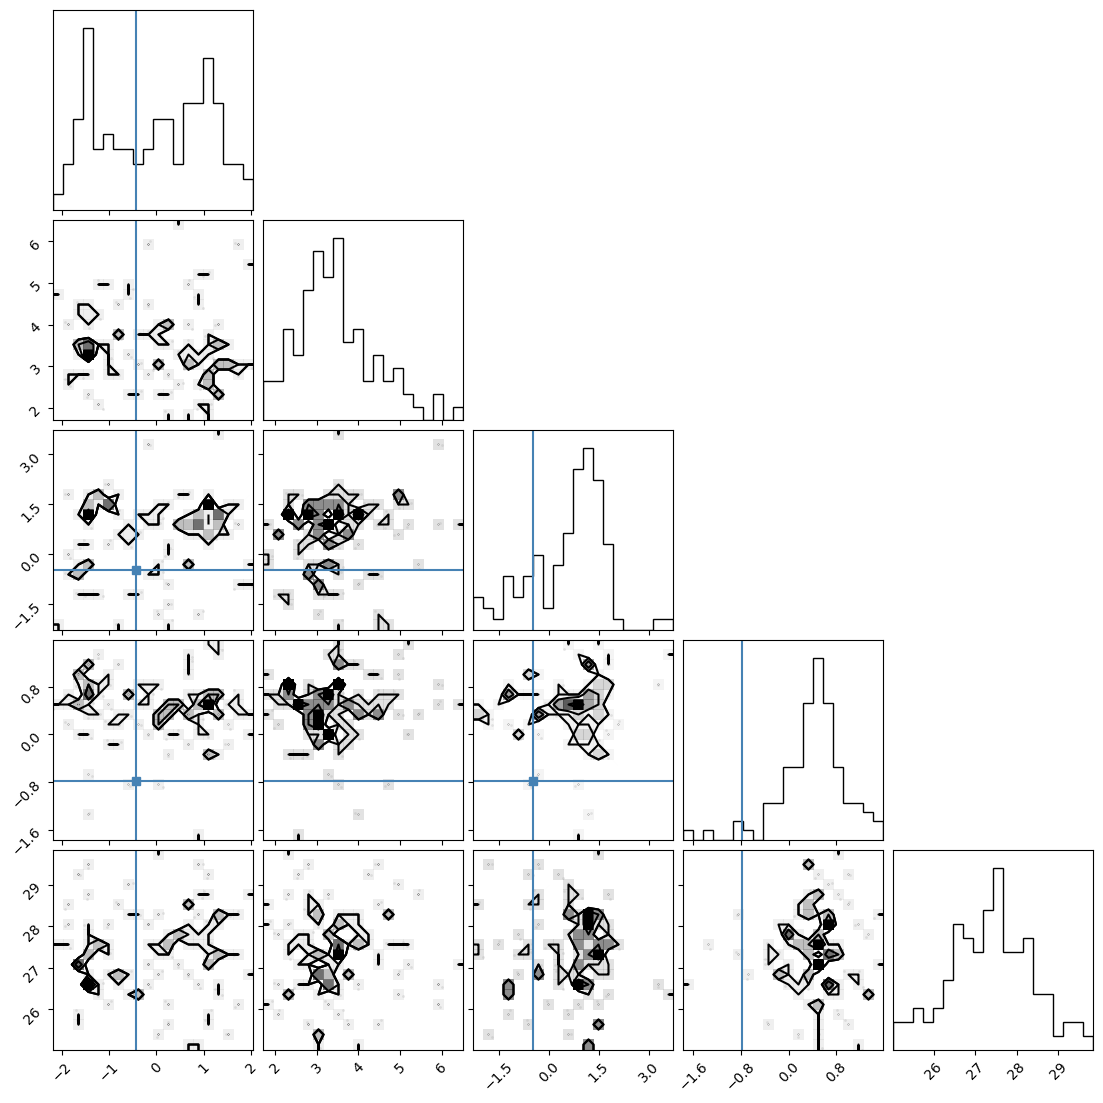

In [24]:
corner.corner(samples_post_np[0], truths=test_theta[0]);

(array([0.93984551, 0.23496138, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

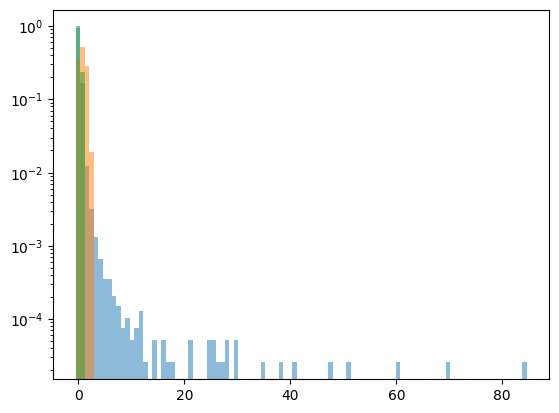

In [40]:
_, bins, _ = plt.hist(sim_data_normed['theta'][:, 0], bins=100, label='true mass', alpha=0.5, density=True, log=True)
plt.hist(samples_post_np[0, :, 0], bins=bins, label='sampled mass', density=True, log=True, alpha=0.5)
plt.hist(test_theta[0], bins=bins, label='test mass', density=True, log=True, alpha=0.5)

In [31]:
sim_data_normed['theta'][:, 0]

array([-0.03361836,  0.01511152, -0.25675844, ..., -0.47170596,
        0.03517516, -0.1006192 ])